<a href="https://colab.research.google.com/github/mohanrajmit/IDD/blob/master/seg_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/mohanrajmit/IDD.git

Cloning into 'IDD'...
remote: Enumerating objects: 4855, done.
remote: Counting objects: 100% (4855/4855), done.
remote: Compressing objects: 100% (4467/4467), done.
remote: Total 4855 (delta 205), reused 4767 (delta 125), pack-reused 0
Receiving objects: 100% (4855/4855), 27.20 MiB | 25.88 MiB/s, done.
Resolving deltas: 100% (205/205), done.


In [0]:
import cv2
from imutils import paths

In [0]:
labels_path= paths.list_images("/content/IDD/idd20k_lite/gtFine")


In [0]:
def binarylab(labels_name):
  #counter=0
  #print(labels_name.shape)
  x = np.zeros([227,320,8])
  for i in range(227):
    for j in range(320):      
      if (labels_name[i][j]>=7):
        #print(counter)
        x[i,j,7]=1
      else:
        x[i,j,labels_name[i][j]]=1

  return x

In [0]:
train_labels=[]
val_labels = []
train_labels_conv = []
val_labels_conv = []
import numpy as np
for imagePath in labels_path:
  #print(imagePath)
  make = imagePath.split("/")[-3]
  #print(make)
  image = cv2.imread(imagePath)
  b,g,r = cv2.split(image)
  binary_label = binarylab(r)
  if make == "train":
    train_labels.append(image)
    train_labels_conv.append(binary_label)
  else:
    val_labels.append(image)
    val_labels_conv.append(binary_label)
#print(images_path[0])

In [9]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
train_labels_conv = np.array(train_labels_conv)
val_labels_conv = np.array(val_labels_conv)
#sample= train_laebls[0]
print(train_labels.shape)

(1403, 227, 320, 3)


In [0]:
train_labels1 = train_labels_conv.reshape(1403,72640,8)
val_labels1 = val_labels_conv.reshape(204,72640,8)

In [11]:
print(train_labels1.shape)

(1403, 72640, 8)


In [0]:
images_path=paths.list_images("/content/IDD/idd20k_lite/leftImg8bit")

In [0]:
train_images = []
val_images = []
test_images = []
import numpy as np
for imagePath in images_path:
  #print(imagePath)
  make = imagePath.split("/")[-3]
  #print(make)
  image = cv2.imread(imagePath)
  if make == "train":
    train_images.append(image)
  elif make == "test":
    test_images.append(image)
  else:
    val_images.append(image)

In [0]:
train_images = np.array(train_images)
val_images = np.array(val_images)
test_images = np.array(test_images)

In [15]:
print(train_images.shape)
print(test_images.shape)
print(val_images.shape)

(1403, 227, 320, 3)
(404, 227, 320, 3)
(204, 227, 320, 3)


(227, 320, 3)
(227, 320, 3)


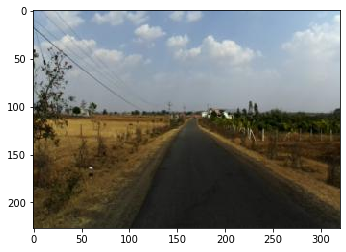

In [16]:
sample_image_label = train_labels[0]
sample_image = train_images[0]
print(sample_image_label.shape)
print(sample_image.shape)
from matplotlib import pyplot as plt
import imutils
plt.figure("original_image")
plt.imshow(imutils.opencv2matplotlib(sample_image))

In [0]:
Sky = [128,128,128]
Building = [128,0,0]
Road = [128,64,128]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
unknown=[0,0,0]


label_colours = np.array([Sky, Building, Road,Tree, SignSymbol, Car, Pedestrian,unknown])

def visualize(temp, plot=True):
    b,g,r = cv2.split(temp)
    #r = temp.copy()
    #g = temp.copy()
    #b = temp.copy()
    for l in range(0,7):
        r[r==l]=label_colours[l,0]
        g[g==l]=label_colours[l,1]
        b[b==l]=label_colours[l,2]
        r[r==255]=label_colours[7,0]
        g[g==255]=label_colours[7,1]
        b[b==255]=label_colours[7,2]

    rgb = np.zeros((b.shape[0], b.shape[1], 3))
    rgb[:,:,0] = (r)#[:,:,0]
    rgb[:,:,1] = (g)#[:,:,1]
    rgb[:,:,2] = (b)#[:,:,2]
    if plot:
        plt.imshow(rgb)
    else:
        return rgb

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


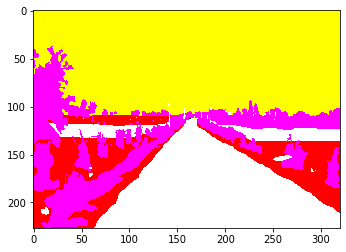

In [18]:
visualize(sample_image_label)

In [19]:
import keras.models as models
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.layers import merge

Using TensorFlow backend.


In [0]:
from keras import backend as K
K.set_image_data_format('channels_last')
from keras.layers import Lambda, Input
import tensorflow as tf

#from keras.backend import tf as ktf

In [23]:
def create_encoding_layers():
    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2
    return [
        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(filter_size, kernel, kernel, border_mode='valid'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2),strides=2),

        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(128, kernel, kernel, border_mode='valid'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(pool_size, pool_size),strides=2),

        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(256, kernel, kernel, border_mode='valid'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(pool_size, pool_size),strides=2),

        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(512, kernel, kernel, border_mode='valid'),
        BatchNormalization(),
        Activation('relu'),
    ]

def create_decoding_layers():
    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2
    return[
        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(512, kernel, kernel, border_mode='valid'),
        BatchNormalization(),

        UpSampling2D(size=(pool_size,pool_size)),
        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(256, kernel, kernel, border_mode='valid'),
        BatchNormalization(),

        UpSampling2D(size=(pool_size,pool_size)),
        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(128, kernel, kernel, border_mode='valid'),
        BatchNormalization(),

        UpSampling2D(size=(pool_size,pool_size)),
        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(filter_size, kernel, kernel, border_mode='valid'),
        BatchNormalization(),
    ]
data_shape = 227*320


segnet_basic = models.Sequential()

segnet_basic.add(Layer(input_shape=(227,320,3)))



segnet_basic.encoding_layers = create_encoding_layers()
for l in segnet_basic.encoding_layers:
    segnet_basic.add(l)

# Note: it this looks weird, that is because of adding Each Layer using that for loop
# instead of re-writting mode.add(somelayer+params) everytime.

segnet_basic.decoding_layers = create_decoding_layers()
for l in segnet_basic.decoding_layers:
    segnet_basic.add(l)

#segnet_basic.add(ZeroPadding2D(padding=(2,0)))

segnet_basic.add(Convolution2D(8, 1, 1, border_mode='valid'))
segnet_basic.add(Lambda(lambda image: tf.image.resize_images(image,(227,320))))
#segnet_basic.add(Reshape(-1,3), input_shape=(224,320,7))
#segnet_basic.add(Lambda(lambda x: x[:508480])) # throw away some, so that #data = 224^2
#segnet_basic.add(Reshape(227,320,7))

#

segnet_basic.add(Reshape((data_shape,8), input_shape=(227,320,8)))
#segnet_basic.add(Permute((2, 1)))
segnet_basic.add(Activation('softmax'))
segnet_basic.compile(loss="categorical_crossentropy", optimizer='adadelta', metrics=["accuracy"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="valid")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="valid")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="valid")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="valid")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="valid")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="valid")`
/usr/local/lib/pyt

In [24]:
segnet_basic.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_2 (Layer)              (None, 227, 320, 3)       0         
_________________________________________________________________
zero_padding2d_9 (ZeroPaddin (None, 229, 322, 3)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 227, 320, 64)      1792      
_________________________________________________________________
batch_normalization_9 (Batch (None, 227, 320, 64)      256       
_________________________________________________________________
activation_6 (Activation)    (None, 227, 320, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 113, 160, 64)      0         
_________________________________________________________________
zero_padding2d_10 (ZeroPaddi (None, 115, 162, 64)     

In [25]:
nb_epoch = 100
batch_size = 16

history = segnet_basic.fit(train_images, train_labels1, batch_size=batch_size,epochs=nb_epoch,verbose=1, validation_data=(val_images, val_labels1))
#segnet_basic.save_weights('model_weight_ep100.hdf5')
#score = autoencoder.evaluate(X_test, X_test, show_accuracy=True, verbose=0)
#print('Test score:', score[0])
#print('Test accuracy:', score[1])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1403 samples, validate on 204 samples
Epoch 1/100
1403/1403 [==============================] - 39s 28ms/step - loss: 1.3296 - acc: 0.5783 - val_loss: 1.2902 - val_acc: 0.5629
Epoch 2/100
1403/1403 [==============================] - 29s 21ms/step - loss: 1.1080 - acc: 0.6169 - val_loss: 1.1870 - val_acc: 0.5733
Epoch 3/100
1403/1403 [==============================] - 30s 21ms/step - loss: 1.0467 - acc: 0.6277 - val_loss: 1.0615 - val_acc: 0.6187
Epoch 4/100
1403/1403 [==============================] - 29s 21ms/step - loss: 1.0187 - acc: 0.6332 - val_loss: 1.0795 - val_acc: 0.6139
Epoch 5/100
1403/1403 [==============================] - 30s 21ms/step - loss: 0.9929 - acc: 0.6402 - val_loss: 1.1088 - val_acc: 0.6078
Epoch 6/100
1403/1403 [==============================] - 30s 21ms/step - loss: 0.9830 - acc: 0.6427 - val_loss: 1.0269 - val_acc: 0.6326
Epoch 7/100
1403/1403 [============